To analyze spinning disk confocal micrsocopy images acquired on 1/30/23 to measure the changes in FRET level of VRK1 FRET probes during mitosis.

40x obj. ch0: CFP, ch1:YFP, ch2: FRET

Segmenation and tracking done using ilastik, using YFP channel average z-projection



In [31]:
from nd2reader import ND2Reader
import numpy as np
import scipy as sp
import os,re,glob
import tifffile
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from functools import reduce
import imageio

import trackpy as tp

from skimage import filters
from skimage import morphology
from skimage import measure
from skimage import segmentation

import seaborn as sns


In [3]:
# data path
fpth = '/home/tyyoo/MitchisonLab/data/SpinningDisk/20230130_cTY107-110_LT/LT_001.nd2'
basename = os.path.basename(fpth)
basename = basename.split('.')[0]
basename

# readnoise background img path
fpth_bg = '/home/tyyoo/MitchisonLab/analysis/FRET_analysis/AVG_read_noise_Station1_20230131.tiff'

# segmentaiont


seg_ch = 1    # ch used for nuclei segmentation
field_def = {'cTY107':[0,1,2],'cTY108':[3,4,5],'cTY109':[6,7,8],'cTY110':[9,10,11]}

crop_pth = os.path.join(os.path.split(fpth)[0],'croped_images/'+basename)
os.makedirs(crop_pth,exist_ok=True)

res_pth = os.path.join(os.path.split(fpth)[0],'results/'+basename)
os.makedirs(res_pth,exist_ok=True)

In [4]:
seg_pth = os.path.join(os.path.split(fpth)[0],'im_for_seg')

lineage_label_pths = glob.glob(os.path.join(seg_pth,basename+'_series*_Tracking-Result.tiff'))


In [85]:
rc = re.compile('%s_series(?P<series>\d+)_Tracking-Result\.tiff' %basename)

fig = plt.figure(dpi=200)
        
for pth in lineage_label_pths:
    lineage_label = tifffile.imread(pth)
    Nlineages = lineage_label.max()
    Nt,Ny,Nx = lineage_label.shape

    colors = cm.rainbow(np.arange(Nlineages+1)/Nlineages)
    np.random.shuffle(colors)
    colors[:2,:] = np.array([[0,0,0,1],[0,0,0,0.1]])
    new_map = mpl.colors.ListedColormap(colors,N=Nlineages+1)

    array_for_tiff=[]
    mpl.use('Agg')
    for t in range(Nt):
        lab_im = lineage_label[t,:,:]
        plt.imshow(lab_im,cmap=new_map,vmin=0,vmax=Nlineages)
        plt.axis('off')

        lineages = np.delete(np.unique(lab_im),0)

        for l in lineages:
            if (l == 1):
                continue
            X,Y = np.meshgrid(np.arange(Nx),np.arange(Ny))
            mask = (lab_im == l)
            xc = X[mask].sum()/mask.sum()
            yc = Y[mask].sum()/mask.sum()

            plt.text(xc,yc,l,horizontalalignment='center',fontdict={'color':'w'})

        fig.canvas.draw()
        array_for_tiff.append(np.array(fig.canvas.renderer.buffer_rgba(),np.uint8))
        fig.clear()

    imageio.mimsave(pth.split('.')[0]+'_annotated.tiff', array_for_tiff, format='tif')
    



<Figure size 1200x800 with 0 Axes>

In [145]:
lineage_selection = {'series07':[[6],[18],[21,47],[13],[23]],'series08':[[23,52,65]],'series09':[[3],[24]],
                    'series10':[[29,47],[3],[26]],'series11':[[9],[32]],'series12':[[7,67,69],[14],[18,55],[26],[20,61],[28,71]]}

In [87]:
bg_im = tifffile.imread(fpth_bg)

In [88]:
images = ND2Reader(fpth)

metadata = images.metadata
Nframes = metadata['num_frames']
Nfields = len(metadata['fields_of_view'])
chs = metadata['channels']
Nch = len(chs)

z_lvs = metadata['z_levels']
Nz = len(z_lvs)

loops = metadata['experiment']['loops']
dt = loops[0]['sampling_interval']/1000   # in sec

/home/tyyoo/anaconda3/lib/python3.7/site-packages/nd2reader/common_raw_metadata.py:94: RuntimeWarning: Reported average frame interval (180003.8 ms) doesn't match the set interval (180000.0 ms). Using the average now.
  warnings.warn(message % (avg_interval, interval), RuntimeWarning)


In [89]:
def seg_nuclei(im):
    im_blur = filters.gaussian(im,sigma=4)
    
    block_size = 401
    
    n,bins = np.histogram(im_blur.flatten(),bins=1000)
    #offset = bins[n.argmax()]*0.8
    offset = 0

    #thres = filters.threshold_local(im_blur, block_size,offset=-offset,param=200)
    #thres = filters.threshold_otsu(im_blur)
    #thres = filters.threshold_niblack(im_blur,window_size=block_size)
    #thres = filters.threshold_sauvola(im_blur,window_size=151,k=0.1)
    thres = filters.rank.otsu((im_blur/im_blur.max()*256).astype(np.int8),morphology.disk(15))
    
    
    label = im_blur > thres.astype(float)/256*im_blur.max()
    label = morphology.erosion(morphology.erosion(label))
    label = morphology.remove_small_objects(label,min_size=1200)
    label = morphology.remove_small_holes(label,area_threshold=200)
    #label = segmentation.clear_border(label)
    label = measure.label(label)
    
    return label

def get_z_proj(images,**kwargs):
    Nz = images.sizes['z']
    
    im = []
    for z in range(Nz):
        im.append(images.get_frame_2D(z=z,**kwargs))

    im = np.array(im).mean(axis=0)
    
    return im


In [146]:

series_list = list(lineage_selection.keys())
series_list = [np.int(s[-2:]) for s in series_list]

dict_list = []
    
for series in series_list:
    v = series-1
    lineage_pth = os.path.join(seg_pth,basename+'_series%02d_Tracking-Result.tiff' %series)
    lineage_label = tifffile.imread(lineage_pth)
    Nt,Ny,Nx = lineage_label.shape

    LOIs = lineage_selection['series%02d' %series]   #lineage sets of interest
    N_LOIs = len(LOIs)

    LOI_id = 0
    for LOI in LOIs:
        Nl = len(LOI)

        for t in range(Nt):
            label_im = lineage_label[t,:,:]

            mask = np.zeros((Ny,Nx)).astype(bool)

            for l in LOI:
                mask = (mask | (label_im==l))

            mask = mask.astype(int)

            if (mask.sum()==0):
                continue

            # label prop
            rp = measure.regionprops(mask)[0]
            d = {'field_ind':v,'time_ind':t,'LOI_id':LOI_id,'lineages':LOI,
                 'area':rp.area,'eccen':rp.eccentricity,'x':rp.centroid[0],'y':rp.centroid[1]}

            for ch in range(Nch):
                im_ch = get_z_proj(images,c=ch,t=t,v=v)
                rp = measure.regionprops(mask,im_ch)[0]

                d['meanint_%d' %ch] = rp.mean_intensity

            # background int
            rp = measure.regionprops(mask,bg_im)[0]

            d['meanint_bg'] = rp.mean_intensity

            dict_list.append(d)

        LOI_id += 1
    
df_all =  pd.DataFrame(dict_list)

/home/tyyoo/anaconda3/lib/python3.7/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/home/tyyoo/anaconda3/lib/python3.7/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


In [147]:
for ch in range(Nch):
    df_all['meanint_%d_corr' %ch] = df_all['meanint_%d' %ch] - df_all['meanint_bg']
    
df_all['FRET_CFP_ratio'] = df_all['meanint_2_corr']/df_all['meanint_0_corr']
df_all['FRET_YFP_ratio'] = df_all['meanint_2_corr']/df_all['meanint_1_corr']

In [148]:
df_all['time'] = df_all['time_ind']*dt/60   # in minutes

In [150]:
def_rearr = {f:k for k,fields in field_def.items() for f in fields}
df_all['class'] = [def_rearr[f] for f in df_all['field_ind']]

In [151]:
df_all.head()

,field_ind,time_ind,LOI_id,lineages,area,eccen,x,y,meanint_0,meanint_1,meanint_2,meanint_bg,meanint_0_corr,meanint_1_corr,meanint_2_corr,FRET_CFP_ratio,FRET_YFP_ratio,time,class
0,6,0,0,[6],13996,0.784070,184.088239,280.749286,172.848171,312.374845,163.850171,100.384560,72.463611,211.990286,63.465612,0.875827,0.299380,0.000000,cTY109
1,6,1,0,[6],13918,0.784308,182.098003,277.663314,172.081453,313.205202,163.488648,100.383751,71.697702,212.821451,63.104897,0.880152,0.296516,3.000063,cTY109
2,6,2,0,[6],14054,0.772728,181.941156,277.295859,170.127888,308.538992,162.193824,100.396172,69.731716,208.142821,61.797652,0.886220,0.296900,6.000125,cTY109
3,6,3,0,[6],13877,0.789074,184.691576,275.531887,169.089717,305.575437,160.844539,100.404419,68.685298,205.171018,60.440120,0.879957,0.294584,9.000188,cTY109
4,6,4,0,[6],13869,0.814971,191.368376,271.431394,167.857380,301.263273,159.397601,100.435844,67.421535,200.827429,58.961757,0.874524,0.293594,12.000251,cTY109


<Figure size 1800x1200 with 0 Axes>

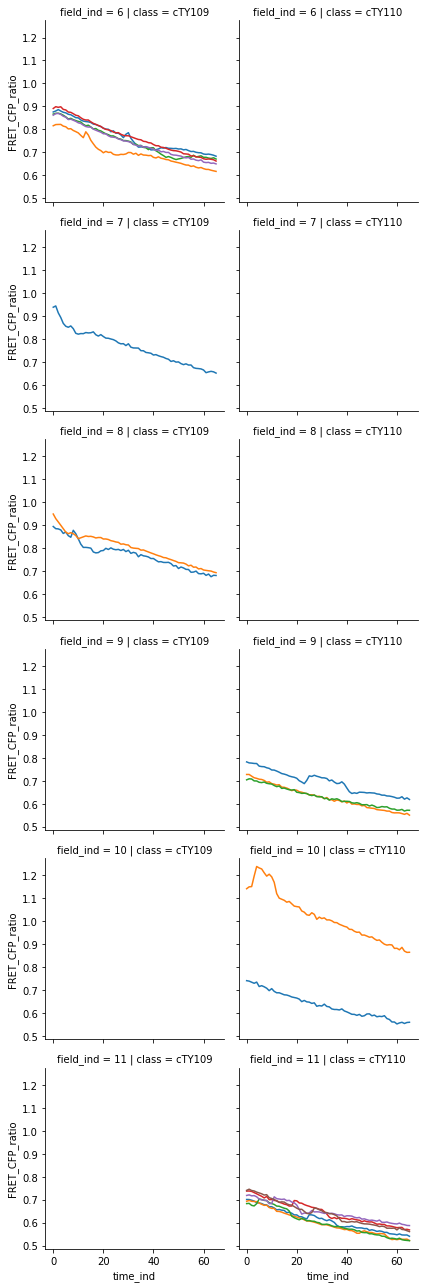

In [156]:
plt.figure(dpi=300)
g = sns.FacetGrid(col='class',row='field_ind',data=df_all,hue='LOI_id')
g.map(sns.lineplot,'time_ind','FRET_CFP_ratio')

/home/tyyoo/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/tyyoo/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/tyyoo/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/hom

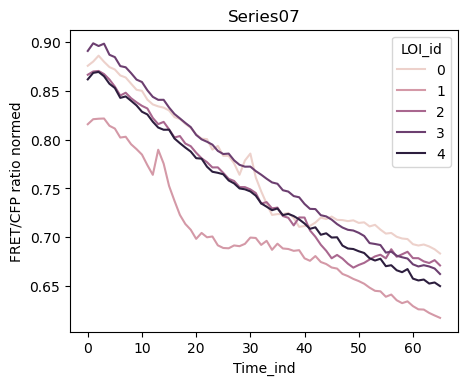

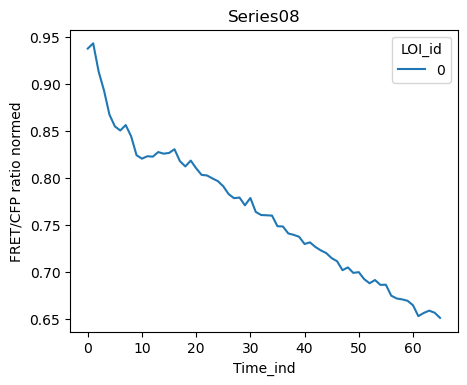

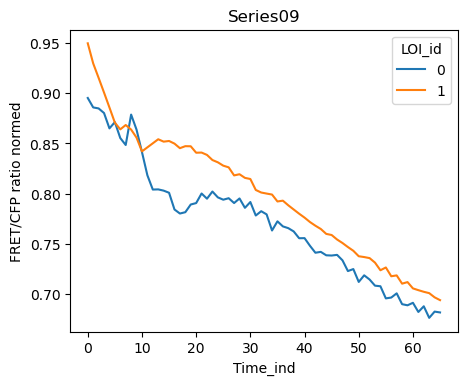

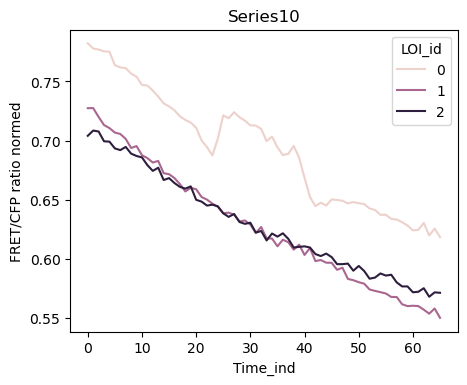

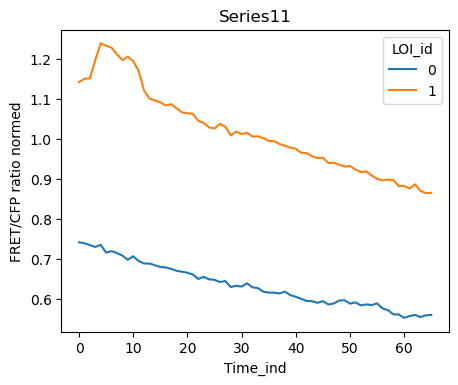

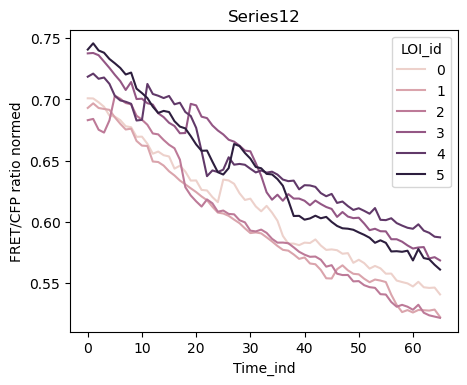

In [159]:
grp_f = df_all.groupby('field_ind')

for f,df_f in grp_f:
    fig = plt.figure(figsize=(5,4),dpi=100)
    
    sns.lineplot('time_ind','FRET_CFP_ratio',data=df_f,hue='LOI_id')
    
    plt.xlabel('Time_ind')
    plt.ylabel('FRET/CFP ratio normed')
    plt.title('Series%02d' %(f+1))
    
    fig.savefig(os.path.join(res_pth,'%s_%02d_FRET_CFP_ratio_normed.png' %(basename,f+1)))    
    

/home/tyyoo/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/tyyoo/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/tyyoo/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/hom

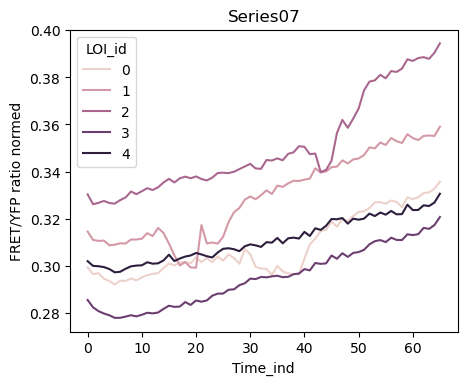

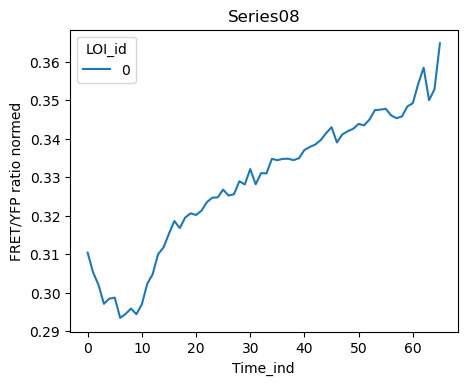

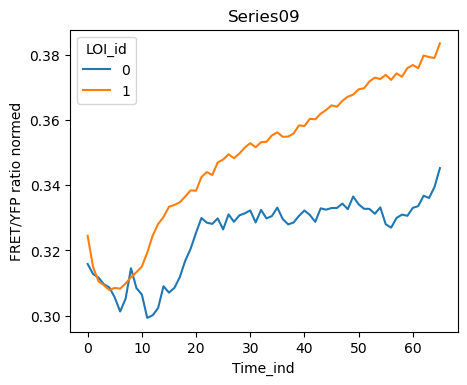

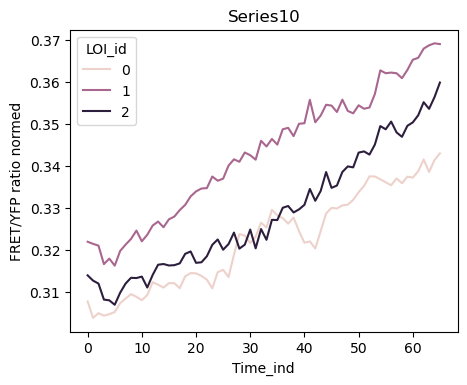

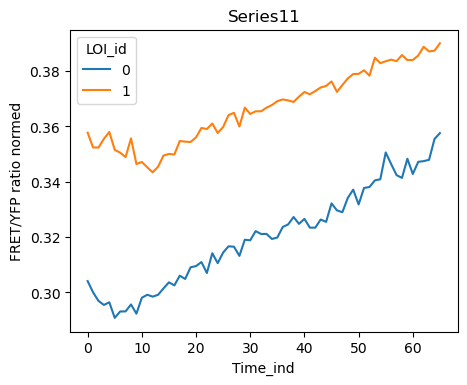

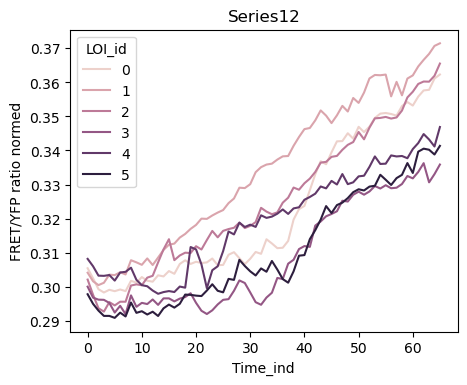

In [160]:
grp_f = df_all.groupby('field_ind')

for f,df_f in grp_f:
    fig = plt.figure(figsize=(5,4),dpi=100)
    
    sns.lineplot('time_ind','FRET_YFP_ratio',data=df_f,hue='LOI_id')
    
    plt.xlabel('Time_ind')
    plt.ylabel('FRET/YFP ratio normed')
    plt.title('Series%02d' %(f+1))
    
    fig.savefig(os.path.join(res_pth,'%s_%02d_FRET_YFP_ratio_normed.png' %(basename,f+1)))    
    

In [161]:
df_all.to_csv(os.path.join(res_pth,'measured_intensity.csv'))
